In [214]:
# initialization

import numpy as np
import math
import random
import itertools
from scipy.optimize import root
import copy
import time


# set resource number and amount
Nr = 4
Res = [1.0, 1.0, 1.0, 1.0]

# generate species pool: growth rate from gaussian; preference list; invasion order
# growth rates
Size = 10 # number of samples from each species
Nb = math.factorial(Nr)*Size
g_mean, g_var = 1, 0.2
# budget 8
growth_rate_list = np.exp(np.random.normal(g_mean, math.sqrt(g_var), (Nb, Nr)))
filt = np.heaviside(growth_rate_list, 0)
growth_rate_list = filt*growth_rate_list
budget = 8
growth_rate_list = budget*growth_rate_list / np.sum(growth_rate_list, axis=1)[:, None]
#preference list
preference_list = list(itertools.permutations(range(Nr), Nr))
b0 = 1e-5 # density of bug when introduced/initial
b_threshold = 1e-5 # extinction density
c_threshold = 1e-9 # concentration threshold
# invasion order
invasion_list = list(range(Nb))
random.shuffle(invasion_list)
# yields
yields_list = 0.5*np.ones([Nb, Nr]) # might need to be modified later?

# dilution parameters
D = 1e-3
tau = 0 # lag
T_dilute = 10 # time interval between dilutions
dilute_to_steady = 10 # #(dilution) between invasions

def dilute(system):
    global t_system
    t_switch = 0
    while t_switch < T_dilute:
        #list of resource in use for each consumer
        use = [0 for i in range(Nb)]
        # list of consumers for each resource
        consumer = [[] for i in range(Nr)]
        for i in range(Nb):
            # if all are depleted, bug still uses its least preferred nutrient
            while system['res_available'][preference_list[i//Size][use[i]]] < 1 and use[i] < Nr - 1:
                use[i] = use[i] + 1
            if system['bug_available'][i] > 0:
                consumer[preference_list[i//Size][use[i]]].append(i)
        # find the earliest depleted resource
        t_dep = T_dilute - t_switch
        for i in range(Nr):
            if system['res_available'][i] > 0:
                def remain(t):
                    # S = c - sum(B0(e^gt-1)/Y)
                    return system['res_concentration'][i] - sum([system['bug_density'][j]*(math.exp(t*growth_rate_list[j][i]) - 1)/yields_list[j][i] for j in consumer[i]])
                # a little bit tricky here...
                t_i = root(remain, T_dilute + 1).x[0]
                if t_i < t_dep:
                    t_dep = t_i
        # update the system according to this t_dep
        t_switch = t_switch + t_dep
        temp_bug_density = [i for i in system['bug_density']]
        for i in range(Nb):
            if system['res_available'][preference_list[i//Size][use[i]]] > 0:
                temp_bug_density[i] = system['bug_density'][i]*math.exp(growth_rate_list[i][preference_list[i//Size][use[i]]]*t_dep)
        for i in range(Nr):
            if system['res_available'][i] > 0:
                system['res_concentration'][i] = system['res_concentration'][i] - sum([system['bug_density'][j]*(math.exp(t_dep*growth_rate_list[j][i]) - 1)/yields_list[j][i] for j in consumer[i]])
                if system['res_concentration'][i] < c_threshold:
                    system['res_available'][i] = 0
        for i in range(Nb):
            system['bug_density'][i] = temp_bug_density[i]
    #print(system)
    system_copy = copy.deepcopy(system)
    t_system.append(system_copy)
    #print("diluted once")
    return system

def dilute_check(system):
    t_points = []
    c_points = []
    r_points = []
    global t_system
    t_switch = 0
    t_points.append(t_switch)
    survivors, concent, pref_list, growth = output(system)
    c_points.append(concent)
    while t_switch < T_dilute:     
        a = [i for i in system['res_available']]
        r_points.append(a)
        #list of resource in use for each consumer
        use = [0 for i in range(Nb)]
        # list of consumers for each resource
        consumer = [[] for i in range(Nr)]
        for i in range(Nb):
            # if all are depleted, bug still uses its least preferred nutrient
            while system['res_available'][preference_list[i//Size][use[i]]] < 1 and use[i] < Nr - 1:
                use[i] = use[i] + 1
            if system['bug_available'][i] > 0:
                consumer[preference_list[i//Size][use[i]]].append(i)
        # find the earliest depleted resource
        t_dep = T_dilute - t_switch
        for i in range(Nr):
            if system['res_available'][i] > 0:
                def remain(t):
                    # S = c - sum(B0(e^gt-1)/Y)
                    return system['res_concentration'][i] - sum([system['bug_density'][j]*(math.exp(t*growth_rate_list[j][i]) - 1)/yields_list[j][i] for j in consumer[i]])
                # a little bit tricky here...
                t_i = root(remain, T_dilute + 1).x[0]
                if t_i < t_dep:
                    t_dep = t_i
        # update the system according to this t_dep
        t_switch = t_switch + t_dep
        temp_bug_density = [i for i in system['bug_density']]
        for i in range(Nb):
            if system['res_available'][preference_list[i//Size][use[i]]] > 0:
                temp_bug_density[i] = system['bug_density'][i]*math.exp(growth_rate_list[i][preference_list[i//Size][use[i]]]*t_dep)
        for i in range(Nr):
            if system['res_available'][i] > 0:
                system['res_concentration'][i] = system['res_concentration'][i] - sum([system['bug_density'][j]*(math.exp(t_dep*growth_rate_list[j][i]) - 1)/yields_list[j][i] for j in consumer[i]])
                if system['res_concentration'][i] < c_threshold:
                    system['res_available'][i] = 0
        for i in range(Nb):
            system['bug_density'][i] = temp_bug_density[i]
        t_points.append(t_switch)
        survivors, concent, pref_list, growth = output(system)
        c_points.append(concent)
        
    #print(system)
    system_copy = copy.deepcopy(system)
    t_system.append(system_copy)
    #print("diluted once")
    return system, t_points, c_points, r_points

def move_to_new(system):
    system['bug_density'] = [(i*D > b_threshold)*i*D for i in system['bug_density']]
    system['bug_available'] = [1*(system['bug_density'][i] > b_threshold) for i in range(Nb)]
    system['res_concentration'] = [(system['res_concentration'][i]*D + Res[i]) / (D + 1) for i in range(Nr)]
    system['res_available'] = [1*(system['res_concentration'][i] > c_threshold) for i in range(Nr)]
    return system

def invade(system, bug):
    #print("one invasion")
    # (starting from a new flask)
    # then add invasive species
    system1 = copy.deepcopy(system)
    system['bug_available'][bug] = 1
    system['bug_density'][bug] = b0
    # then dilute till steady
    system, t_points, c_points, r_points = dilute_check(system)
    accum = 0
    for idx in range(len(t_points[:-2])):
        t_slot = t_points[idx + 1] - t_points[idx]
        pref_bug = preference_list[bug//Size]
        i = 0
        while(r_points[idx][pref_bug[i]] < 0): i += 1
        accum += t_slot*growth_rate_list[bug][preference_list[bug//Size][i]]
#     if system['bug_density'][bug] < b0/D:
#         system = system1
#         ext_list = [i for i, v in enumerate(system['bug_available']) if v==0]
#         #print(system)
#         return system, ext_list
    if accum < math.log(1/D):
        ext_list = [i for i, v in enumerate(system1['bug_available']) if v==0]
        return system1, ext_list
        
    for i in range(dilute_to_steady):
        system = dilute(system)
        # move to a new flask
        system = move_to_new(system)
    ext_list = [i for i, v in enumerate(system['bug_available']) if v==0]
    #print(system)
    return system, ext_list

def round_robin_invade(system, ext_list):
    for bug in ext_list:
        system, new_ext_list = invade(system, bug)
    return system, new_ext_list

def output(system):
    survivors = [i for i, v in enumerate(system['bug_available']) if v != 0]
    pref_list = []
    concent = []
    growth = []
    for i in survivors:
        pref_list.append(preference_list[i//Size])
        concent.append(system['bug_density'][i])
        growth.append(growth_rate_list[i])
    return survivors, concent, pref_list, growth

In [22]:
start = time.time()
Res_copy = [i for i in Res]
system = {'res_available': np.heaviside(Res, 0), 'res_concentration': Res_copy, 'bug_available': [0 for i in range(Nb)], 'bug_density': [0 for i in range(Nb)]}
t_system = [system] # snapshots of systems at the end of each dilution
# ext_list: list of bugs not in the community
old_ext_list = invasion_list
print(old_ext_list)
system, new_ext_list = round_robin_invade(system, old_ext_list)
count = 0
while new_ext_list != old_ext_list and count < 100:
    old_ext_list = new_ext_list
    survivors, concent, pref_list, growth = output(system)
    print(survivors)
    system, new_ext_list = round_robin_invade(system, old_ext_list)
    count = count + 1
end = time.time()
print(end - start)

[130, 18, 135, 66, 193, 62, 147, 221, 181, 162, 69, 159, 67, 27, 113, 58, 197, 7, 85, 172, 21, 122, 41, 73, 117, 213, 158, 50, 165, 206, 238, 129, 132, 134, 196, 40, 138, 30, 203, 61, 143, 124, 92, 182, 219, 42, 115, 133, 107, 106, 166, 174, 43, 210, 88, 161, 13, 222, 6, 101, 151, 25, 15, 79, 155, 119, 75, 121, 19, 152, 84, 234, 180, 144, 145, 56, 127, 218, 199, 201, 188, 140, 26, 191, 116, 97, 96, 169, 229, 160, 137, 64, 54, 168, 157, 83, 220, 74, 95, 0, 47, 178, 153, 211, 103, 48, 170, 217, 232, 200, 184, 216, 224, 59, 231, 194, 141, 31, 239, 5, 150, 136, 230, 164, 2, 102, 198, 156, 55, 111, 4, 72, 175, 195, 128, 226, 77, 167, 186, 177, 8, 44, 110, 17, 63, 192, 60, 202, 93, 109, 70, 94, 236, 24, 90, 233, 225, 179, 81, 125, 212, 9, 183, 68, 173, 3, 57, 14, 45, 39, 99, 51, 209, 20, 142, 35, 65, 207, 189, 112, 98, 82, 22, 227, 105, 53, 223, 100, 76, 49, 38, 29, 131, 176, 171, 146, 89, 28, 34, 139, 32, 208, 12, 204, 104, 190, 214, 23, 52, 154, 163, 114, 123, 185, 228, 118, 148, 10, 86, 1

In [23]:
system, t_points, c_points, r_points = dilute_check(system)

In [24]:
r_points

[[1, 1, 1, 1], [1, 0, 1, 1], [1, 0, 1, 0], [0, 0, 1, 0], [0, 0, 0, 0]]

In [33]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def plot_triangle(A, B, C):
    x = [A[0], B[0], C[0], A[0]]
    y = [A[1], B[1], C[1], A[1]]
    ax = plt.gca()
    ax.plot(x, y, linewidth=2)

def draw_circle(x, y, r):
    ax = plt.gca()
    cir = Circle(xy=(x, y), radius=r, alpha=0.5)
    ax.add_patch(cir)
    ax.plot()
    
def project(data):
    draw_circle((data[3][0][1]-data[3][0][0])/math.sqrt(2)/sum(data[3][0]), data[3][0][2]*math.sqrt(6)/2/sum(data[3][0]), 0.02)
    draw_circle((data[3][1][1]-data[3][1][0])/math.sqrt(2)/sum(data[3][1]), data[3][1][2]*math.sqrt(6)/2/sum(data[3][1]), 0.02)
    draw_circle((data[3][2][1]-data[3][2][0])/math.sqrt(2)/sum(data[3][2]), data[3][2][2]*math.sqrt(6)/2/sum(data[3][2]), 0.02)

In [173]:
import collections
import math

def preproc(outputs):
    S = []
    for i in range(len(outputs[0][2][0])):
        S_data = []
        for output_case in outputs:
            S_data.append([preflist[i] for preflist in output_case[2]])
        S.append(S_data)
    return S
    
def getEntropy(list0):
    d = collections.Counter(list0)
    freqs = [d[i] for i in list(set(list0))]
    #freqs = [d[i] for i in list0]
    summed = sum(freqs)
    return sum(-(i/summed)*math.log(i/summed) for i in freqs)

def getEntropies(S):
    y = []
    for elem in S:
        y.append(np.mean([getEntropy(lst) for lst in elem]))
    return y

In [183]:
start = time.time()
outputs_0 = []
for i in range(40):
    growth_rate_list = np.exp(np.random.normal(g_mean, math.sqrt(g_var), (Nb, Nr)))
    filt = np.heaviside(growth_rate_list, 0)
    growth_rate_list = filt*growth_rate_list
    budget = 8
    growth_rate_list = budget*growth_rate_list / np.sum(growth_rate_list, axis=1)[:, None]
    Res_copy = [i for i in Res]
    system = {'res_available': np.heaviside(Res, 0), 'res_concentration': Res_copy, 'bug_available': [0 for i in range(Nb)], 'bug_density': [0 for i in range(Nb)]} 
    t_system = [system] # snapshots of systems at the end of each dilution
    # ext_list: list of bugs not in the community
    old_ext_list = invasion_list
    #print(old_ext_list)
    system, new_ext_list = round_robin_invade(system, old_ext_list)
    count = 0
    while new_ext_list != old_ext_list and count < 100:
        old_ext_list = new_ext_list
        survivors, concent, pref_list, growth = output(system)
        #print(survivors)
        system, new_ext_list = round_robin_invade(system, old_ext_list)
        count = count + 1
    if (len(output(system)[0]) < 4):
        outputs_0.append(output(system))
        print(survivors)
end = time.time()
print(end-start)

[15, 47]
[38, 40, 55]
[27, 42, 47]
[27, 57]
[22, 37, 57]
[5, 22, 41]
[0, 44]
[36, 52]
[8, 32, 56]
[3, 39, 41]
[39, 41]
[6, 34, 49]
[15, 30, 53]
[12, 22, 52]
[4, 34, 42]
[0, 35, 42]
[15, 24, 56]
[10, 45]
[31, 43, 57]
[9, 44, 53]
[3, 27]
[12, 36, 48]
[8, 16, 24]
[15, 33, 41]
[12, 45]
[28, 46]
[17, 25]
[17, 35, 45]
[19, 30, 53]
[12, 37, 40]
[18, 23, 50]
[13, 28, 55]
[12, 38, 56]
[0, 29, 53]
[39, 57]
21.995866298675537


In [186]:
lst_3_new = getEntropies(preproc(outputs_0))

In [187]:
lst_3_new

[0.8919635769129786, 0.7747564320245631, 0.6543131150067115]

Text(0,0.5,'entropy')

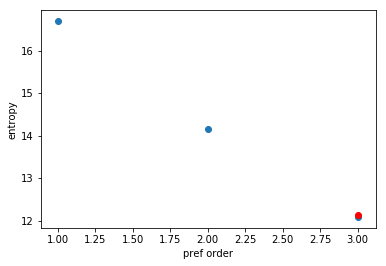

In [91]:
plt.scatter(range(1, 4), lst_3)
plt.scatter(3, 12.134972802208758, color = 'r')
plt.xlabel('pref order')
plt.ylabel('entropy')

Text(0,0.5,'entropy')

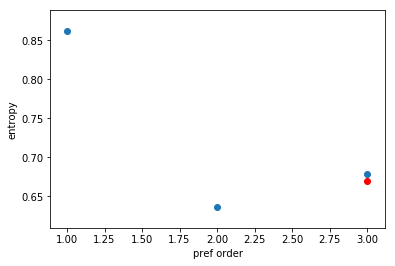

In [193]:
plt.scatter(range(1, 4), lst_3_new)
plt.scatter(3, 0.669123139199454, color = 'r')
plt.xlabel('pref order')
plt.ylabel('entropy')

Text(0,0.5,'entropy')

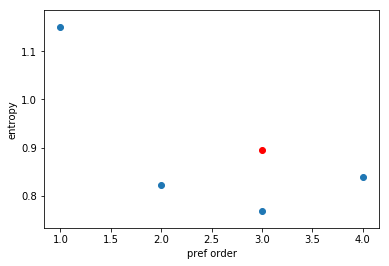

In [164]:
plt.scatter(range(1, 5), lst_4_new)
plt.scatter(3, 0.8949613900461767, color = 'r')
plt.xlabel('pref order')
plt.ylabel('entropy')

In [198]:
randEnts = []
for times in range(5000):
    longsth = []
    for i in preproc(outputs_0)[0]:
        shortsth = [random.randint(0, 3) for j in i] 
        longsth.append(shortsth)

    randEnts.append(getEntropies([longsth]))
    
np.mean(randEnts)

0.6756033722010907

Text(0,0.5,'entropy')

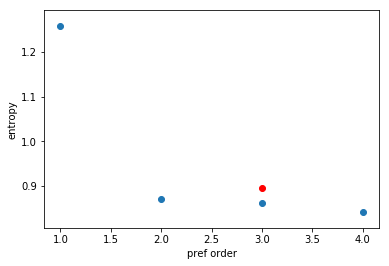

In [177]:
plt.scatter(range(1, 5), lst_4)
plt.scatter(3, 0.8949613900461767, color = 'r')
plt.xlabel('pref order')
plt.ylabel('entropy')

In [209]:
N_i = 15
outputs_0_list = []
for i in range(N_i):
    Res = [1.0 + i*2/(N_i-1), 1.0 - i/(N_i-1), 1.0 - i/(N_i-1)]
    start = time.time()
    outputs_0 = []
    for i in range(40):
        growth_rate_list = np.exp(np.random.normal(g_mean, math.sqrt(g_var), (Nb, Nr)))
        filt = np.heaviside(growth_rate_list, 0)
        growth_rate_list = filt*growth_rate_list
        budget = 8
        growth_rate_list = budget*growth_rate_list / np.sum(growth_rate_list, axis=1)[:, None]
        Res_copy = [i for i in Res]
        system = {'res_available': np.heaviside(Res, 0), 'res_concentration': Res_copy, 'bug_available': [0 for i in range(Nb)], 'bug_density': [0 for i in range(Nb)]} 
        t_system = [system] # snapshots of systems at the end of each dilution
        # ext_list: list of bugs not in the community
        old_ext_list = invasion_list
        #print(old_ext_list)
        system, new_ext_list = round_robin_invade(system, old_ext_list)
        count = 0
        while new_ext_list != old_ext_list and count < 100:
            old_ext_list = new_ext_list
            survivors, concent, pref_list, growth = output(system)
            #print(survivors)
            system, new_ext_list = round_robin_invade(system, old_ext_list)
            count = count + 1
        if (len(output(system)[0]) < 4):
            outputs_0.append(output(system))
            print(survivors)
    end = time.time()
    print(end-start)
    outputs_0_list.append(outputs_0)

[1, 20, 56]
[29, 52]
[10, 39]
[3, 47]
[15, 55]
[7, 15, 55]
[7, 38]
[0, 35, 53]
[8, 22, 59]
[8, 27, 53]
[39, 49]
[1, 41]
[31, 52]
[24, 47]
[2, 35]
[5, 32, 52]
[12, 45, 59]
[8, 38, 46]
[19, 29, 57]
[11, 30, 38]
[26, 38, 49]
[1, 34, 43]
[28, 55]
[16, 36]
[29, 45]
[16, 29, 46]
[27, 44]
[5, 17, 40]
[14, 39, 58]
[2, 29, 40]
[20, 48]
[12, 25, 57]
[15, 54]
19.705262899398804
[13, 23]
[2, 27, 54]
[5, 26, 49]
[25, 28, 40]
[17, 19, 51]
[0, 12, 31]
[27, 51]
[16, 20]
[38, 42, 53]
[9, 28, 41]
[1, 42]
[12, 57]
[10, 22, 49]
[3, 19, 33]
[8, 21, 42]
[29, 55, 57]
[6, 57]
[27, 55]
[14, 25]
[5, 32, 44]
[8, 54]
[8, 39, 42]
[3, 18, 24]
[8, 30, 53]
[5, 25, 45]
[27, 40, 53]
[21, 41, 43]
[19, 34, 45]
[28, 46]
21.091893196105957
[13, 25, 46]
[1, 28, 32]
[3, 23, 59]
[2, 25]
[9, 33, 59]
[9, 34, 43]
[8, 48]
[19, 29]
[1, 21]
[6, 46]
[17, 27, 45]
[10, 38, 49]
[10, 35]
[1, 20, 22]
[9, 22]
[21, 33, 46]
[2, 54]
[9, 33, 48]
[8, 37, 47]
[11, 33]
[5, 29]
[29, 49]
[18, 21, 40]
[3, 17, 52]
[9, 36]
[2, 4, 53]
[6, 15, 57]
[13,

In [210]:
avr_survivors = []
for output0 in outputs_0_list:
    nlist = [len(i[0]) for i in output0]
    avr_survivors.append(np.mean(nlist))
    
Entropy_most_pref = []
for output0 in outputs_0_list:
    lst_entropies = getEntropies(preproc(output0))
    Entropy_most_pref.append(lst_entropies[0])
    
print(avr_survivors)
print(Entropy_most_pref)

[2.515151515151515, 2.6551724137931036, 2.5806451612903225, 2.2058823529411766, 2.4827586206896552, 2.5625, 2.5428571428571427, 2.4864864864864864, 2.4838709677419355, 2.4482758620689653, 2.225806451612903, 2.3142857142857145, 2.2285714285714286, 2.135135135135135, 1.2]
[0.8320082786197123, 0.815386972652892, 0.8242337967965221, 0.6884158566027936, 0.7833623777607294, 0.8778996050857911, 0.7747564320245632, 0.7889567473354978, 0.7980747575637372, 0.7753951687887759, 0.63958507087629, 0.7084842999068854, 0.6424702827107001, 0.5608468496732861, 0.0]


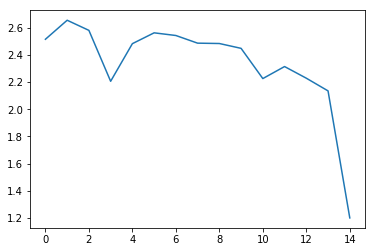

In [211]:
plt.plot(avr_survivors)

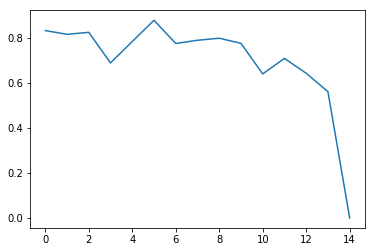

In [212]:
plt.plot(Entropy_most_pref)

In [219]:
N_i = 10
Nr = 4
outputs_0_list_4 = []
for i in range(N_i):
    Res = [1.0 + i*3/(N_i-1), 1.0 - i/(N_i-1), 1.0 - i/(N_i-1), 1.0 - i/(N_i-1)]
    start = time.time()
    outputs_0 = []
    for i in range(40):
        growth_rate_list = np.exp(np.random.normal(g_mean, math.sqrt(g_var), (Nb, Nr)))
        filt = np.heaviside(growth_rate_list, 0)
        growth_rate_list = filt*growth_rate_list
        budget = 8
        growth_rate_list = budget*growth_rate_list / np.sum(growth_rate_list, axis=1)[:, None]
        Res_copy = [i for i in Res]
        system = {'res_available': np.heaviside(Res, 0), 'res_concentration': Res_copy, 'bug_available': [0 for i in range(Nb)], 'bug_density': [0 for i in range(Nb)]} 
        t_system = [system] # snapshots of systems at the end of each dilution
        # ext_list: list of bugs not in the community
        old_ext_list = invasion_list
        #print(old_ext_list)
        system, new_ext_list = round_robin_invade(system, old_ext_list)
        count = 0
        while new_ext_list != old_ext_list and count < 100:
            old_ext_list = new_ext_list
            survivors, concent, pref_list, growth = output(system)
            #print(survivors)
            system, new_ext_list = round_robin_invade(system, old_ext_list)
            count = count + 1
        if (len(output(system)[0]) < 5):
            outputs_0.append(output(system))
            print(survivors)
    end = time.time()
    print(end-start)
    outputs_0_list_4.append(outputs_0)

[48, 91, 159, 213]
[85, 122, 223]
[32, 109, 154, 180]
[55, 87, 157]
[80, 125, 217]
[9, 149, 238]
[24, 126]
[113, 160, 239]
[1, 114, 178, 199]
[32, 95, 144, 186]
[93, 137, 181]
[26, 119, 126]
[32, 92, 142]
[4, 101, 164, 199]
[105, 153]
[4, 61, 144, 203]
[56, 87, 220]
[23, 149, 206]
[33, 119, 121, 130]
[9, 74, 159, 173]
[34, 109, 175]
[2, 121, 201]
[12, 22, 110, 140]
[24, 54, 115, 221]
[26, 150, 210]
[1, 86, 168, 230]
[67, 148, 204]
[0, 31, 105, 223]
[27, 75, 127]
[26, 74, 237]
[46, 62, 149]
[55, 117, 140]
[59, 99, 131]
[26, 93, 194]
[39, 90, 189]
168.04939222335815
[15, 113, 200, 233]
[44, 67, 95, 150]
[56, 60, 141, 230]
[38, 77, 149, 195]
[2, 161, 199]
[4, 76, 120, 234]
[5, 90, 125, 175]
[4, 60, 159, 181]
[90, 235]
[34, 149, 184]
[2, 81, 149, 208]
[0, 72, 198]
[9, 117, 163, 213]
[65, 190]
[31, 72, 154]
[31, 62, 143]
[4, 168, 214]
[22, 86, 235]
[29, 88, 194, 210]
[20, 85, 170, 239]
[97, 125, 182]
[51, 100, 135, 195]
[59, 69, 182, 196]
[3, 169, 222]
[36, 66, 234]
[30, 39, 152, 192]
[23, 

In [216]:
avr_survivors_4 = []
for output0 in outputs_0_list_4:
    nlist = [len(i[0]) for i in output0]
    avr_survivors_4.append(np.mean(nlist))
    
Entropy_most_pref_4 = []
for output0 in outputs_0_list_4:
    lst_entropies = getEntropies(preproc(output0))
    Entropy_most_pref_4.append(lst_entropies[0])
    
print(avr_survivors_4)
print(Entropy_most_pref_4)

[2.8333333333333335, 3.0, 2.8947368421052633, 2.8, 2.8095238095238093, 2.4, 2.4166666666666665, 2.2, 2.3157894736842106, 1.1]
[1.0310347706500824, 1.0986122886681093, 1.007289843564798, 1.017519267046477, 1.02138083950465, 0.7768668835622727, 0.8115960458884149, 0.664830674427379, 0.6481991702913606, 0.0]


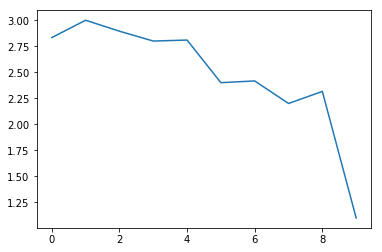

In [217]:
plt.plot(avr_survivors_4)

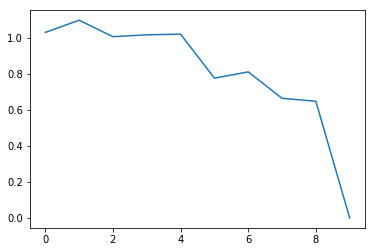

In [218]:
plt.plot(Entropy_most_pref_4)